<a href="https://colab.research.google.com/github/nannthd/project_AIEngineer/blob/main/train_yolov8_newdata2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

In [2]:
# Pip install method (recommended)

!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.2/78.2 GB disk)


In [ ]:
!pip install pytube opencv-python-headless

In [4]:
from ultralytics import YOLO
from IPython.display import display, Image

## Custom Training

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="AWtZRbYK04sFZNNZ1t4X")
project = rf.workspace("projectaiengineer").project("coconuts-cwdpv")
version = project.version(1)
dataset = version.download("yolov8")

In [ ]:
%cat {dataset.location}/data.yaml

In [7]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [ ]:
%cat {dataset.location}/data.yaml

## Custom Training

In [ ]:
%cd {HOME}

!yolo task=detect mode=train epochs=50 imgsz=640 batch=8 plots=True \
model=yolov8m.pt \
data={dataset.location}/data.yaml \
dropout=0.3

In [ ]:
!ls {HOME}/runs/detect/train/

In [11]:
from IPython.display import Image, clear_output

/content


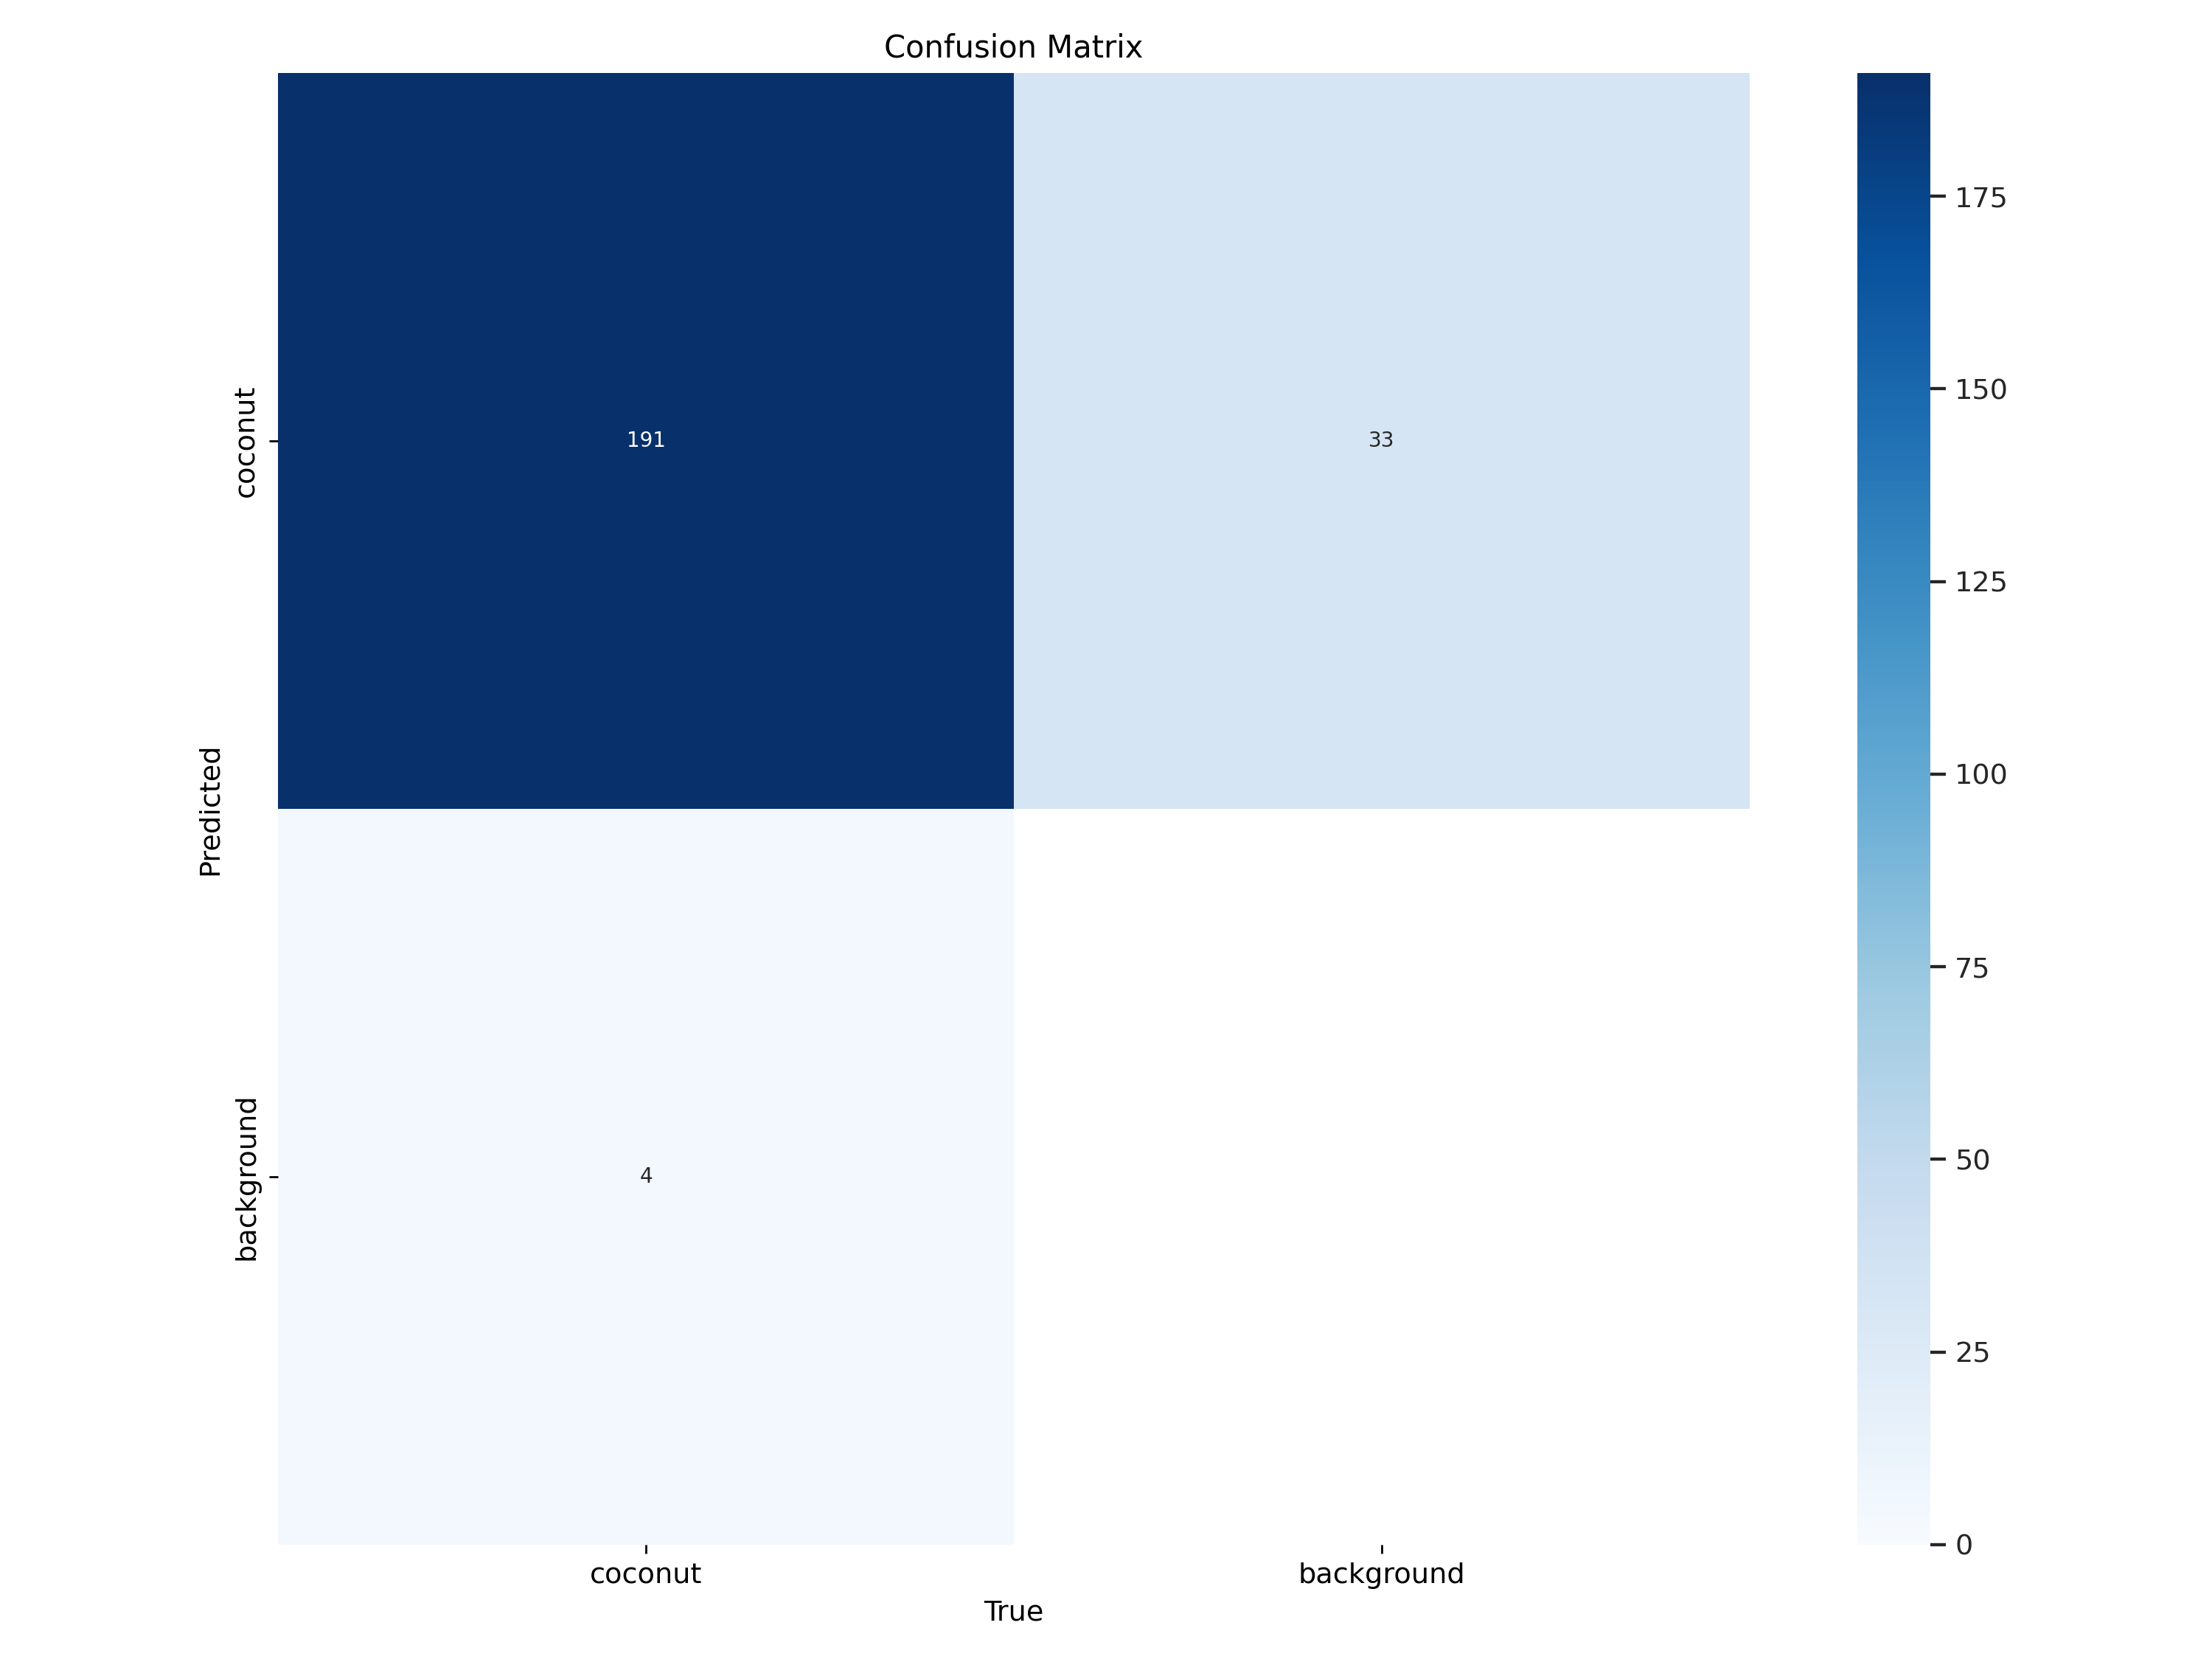

In [12]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


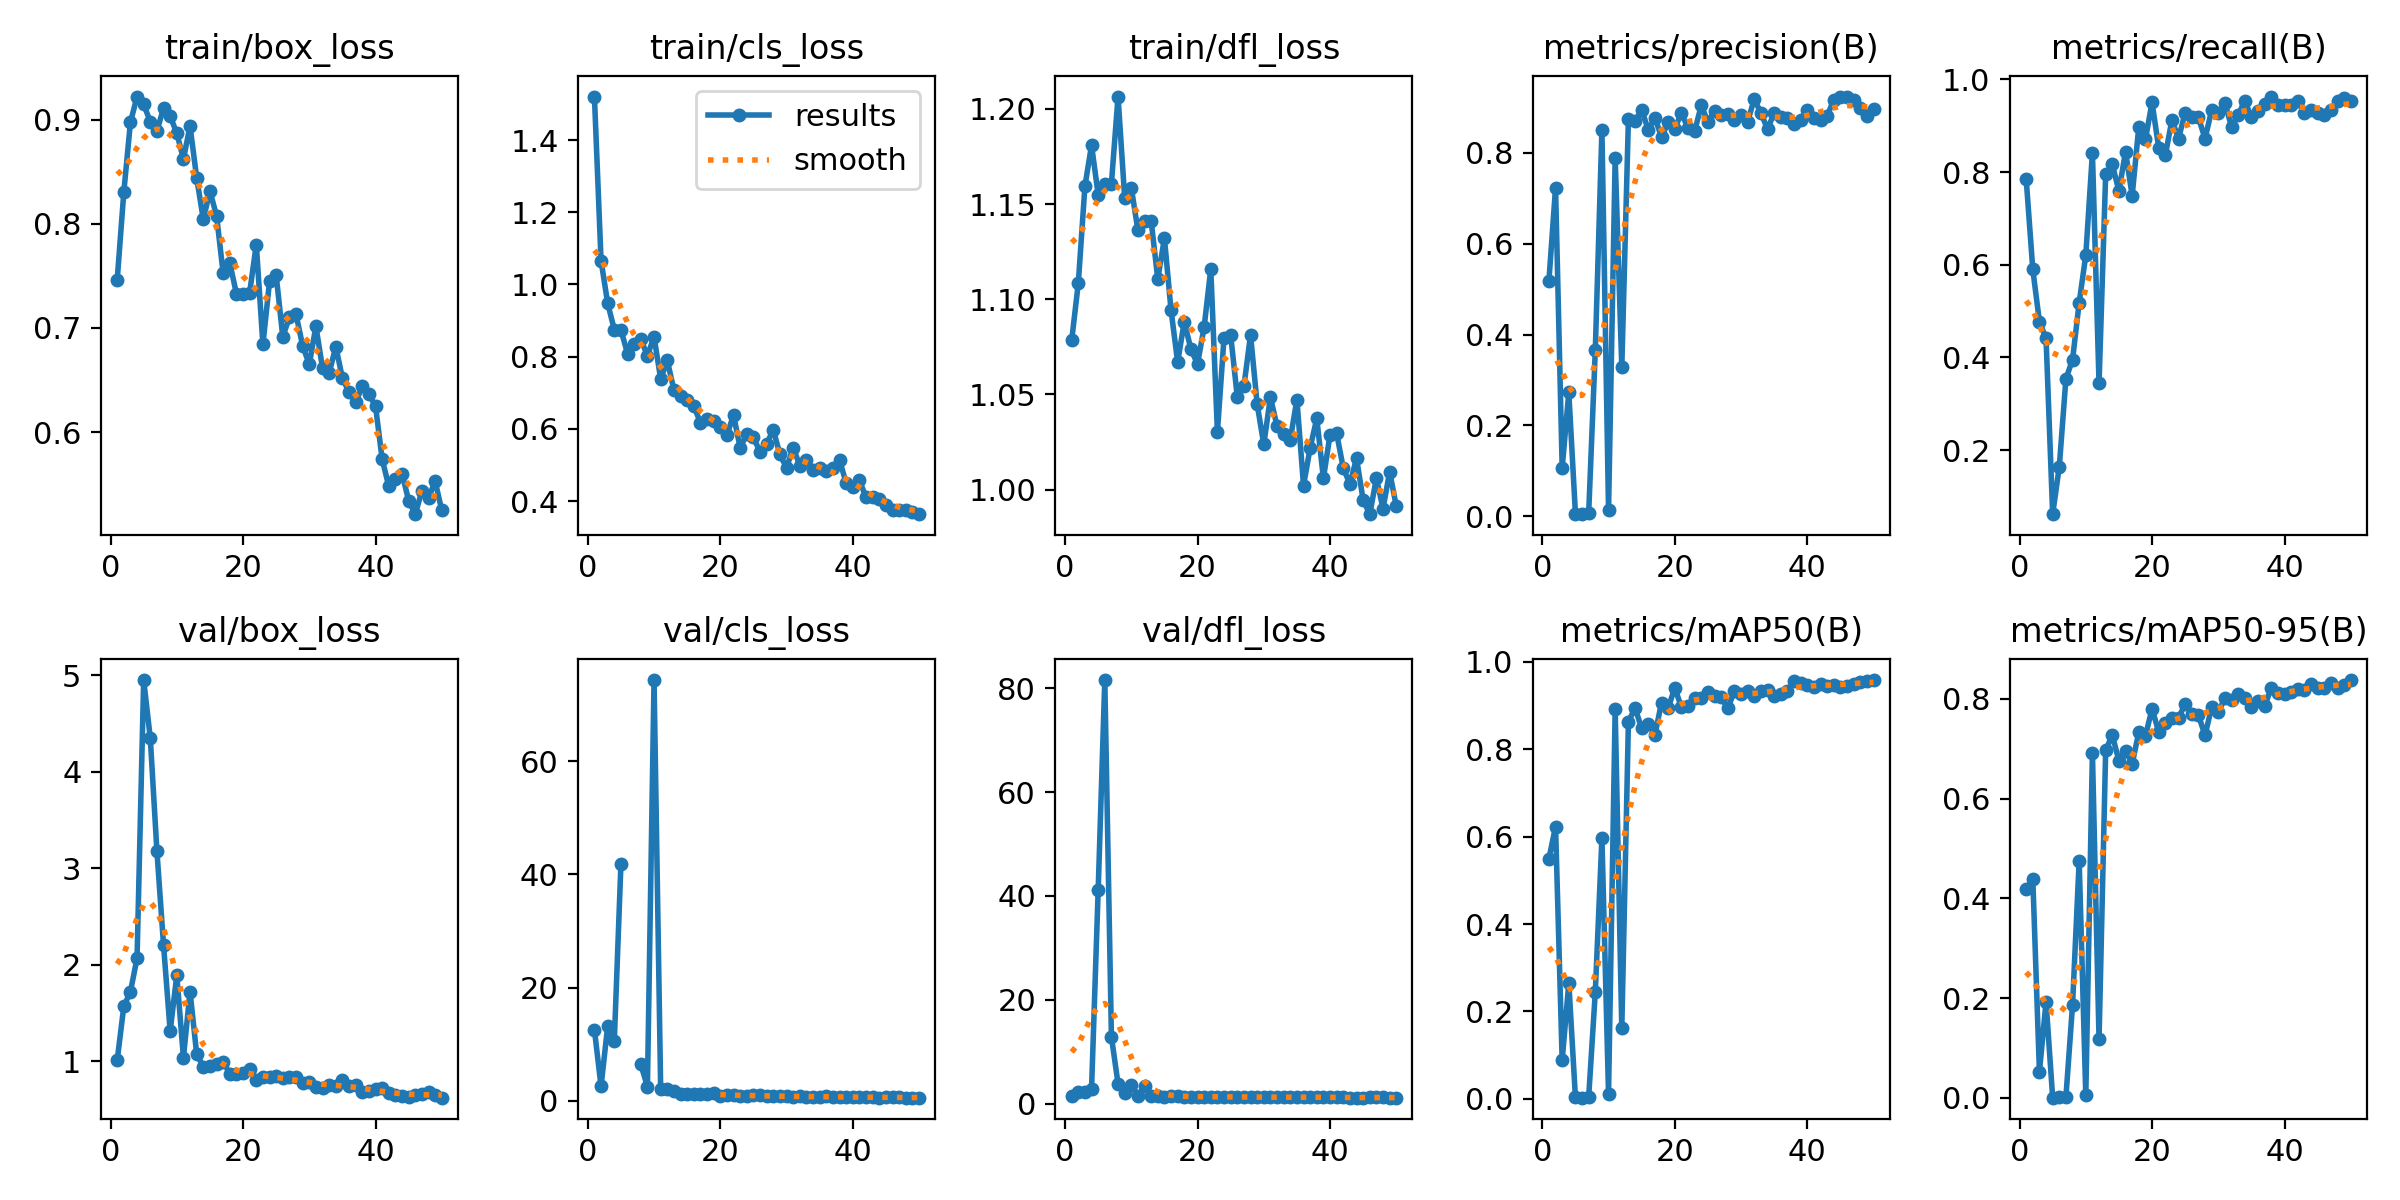

In [13]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

## Inference with Custom Model

**NOTE:** Let's start by loading our newly trained model.

In [ ]:
!pip install supervision
import supervision as sv

In [15]:
from ultralytics import YOLO

model = YOLO(f'{HOME}/runs/detect/train/weights/best.pt')

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/valid/images",
    annotations_directory_path=f"{dataset.location}/valid/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

**NOTE:** Let's randomly select an image from our validation set and visualize the results.

In [ ]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [ ]:
pred = model.predict(random_image, save=True)
pred


0: 640x640 12 coconutss, 38.2ms
Speed: 2.5ms preprocess, 38.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'coconuts'}
 orig_img: array([[[128, 126, 126],
         [127, 125, 125],
         [128, 126, 126],
         ...,
         [ 95, 107, 113],
         [ 88, 100, 106],
         [ 96, 108, 114]],
 
        [[131, 129, 129],
         [130, 128, 128],
         [130, 128, 128],
         ...,
         [ 95, 107, 113],
         [ 87,  99, 105],
         [ 93, 105, 111]],
 
        [[134, 132, 132],
         [133, 131, 131],
         [130, 130, 130],
         ...,
         [ 97, 109, 115],
         [ 90, 102, 108],
         [ 93, 105, 111]],
 
        ...,
 
        [[115, 145, 156],
         [116, 146, 157],
         [117, 147, 158],
         ...,
         [ 58,  57,  47],
         [ 74,  70,  59],
         [112, 108,  97]],
 
        [[114, 146, 157],
         [115, 147, 158],
         [118, 147, 161],
         ...,
         [ 54,  53,  43],
 

#Tracking

In [ ]:
%pip install ultralytics

In [ ]:
# %pip install ultralytics --upgrade

In [ ]:
# import cv2
# from ultralytics import YOLO, solutions

In [18]:
import cv2
from ultralytics import YOLO

In [25]:
model = YOLO("/content/runs/detect/train/weights/best.pt")
model.names

{0: 'coconut'}

In [30]:
# Ultralytics YOLO 🚀, AGPL-3.0 license

from collections import defaultdict

import cv2
import numpy as np

from ultralytics.utils.checks import check_imshow, check_requirements
from ultralytics.utils.plotting import Annotator, colors

check_requirements("shapely>=2.0.0")

from shapely.geometry import LineString, Point, Polygon


class ObjectCounter:
    """A class to manage the counting of objects in a real-time video stream based on their tracks."""

    def __init__(
        self,
        classes_names,
        reg_pts=None,
        count_reg_color=(255, 0, 255),
        count_txt_color=(0, 0, 0),
        count_bg_color=(255, 255, 255),
        line_thickness=2,
        track_thickness=2,
        view_img=False,
        view_counts=True,
        draw_tracks=False,
        track_color=None,
        region_thickness=5,
        line_dist_thresh=15,
        cls_txtdisplay_gap=50,
    ):
        """
        Initializes the ObjectCounter with various tracking and counting parameters.

        Args:
            classes_names (dict): Dictionary of class names.
            reg_pts (list): List of points defining the counting region.
            count_reg_color (tuple): RGB color of the counting region.
            count_txt_color (tuple): RGB color of the count text.
            count_bg_color (tuple): RGB color of the count text background.
            line_thickness (int): Line thickness for bounding boxes.
            track_thickness (int): Thickness of the track lines.
            view_img (bool): Flag to control whether to display the video stream.
            view_counts (bool): Flag to control whether to display the counts on the video stream.
            draw_tracks (bool): Flag to control whether to draw the object tracks.
            track_color (tuple): RGB color of the tracks.
            region_thickness (int): Thickness of the object counting region.
            line_dist_thresh (int): Euclidean distance threshold for line counter.
            cls_txtdisplay_gap (int): Display gap between each class count.
        """

        # Mouse events
        self.is_drawing = False
        self.selected_point = None

        # Region & Line Information
        self.reg_pts = [(20, 400), (1260, 400)] if reg_pts is None else reg_pts
        self.line_dist_thresh = line_dist_thresh
        self.counting_region = None
        self.region_color = count_reg_color
        self.region_thickness = region_thickness

        # Image and annotation Information
        self.im0 = None
        self.tf = line_thickness
        self.view_img = view_img
        self.view_counts = view_counts

        self.names = classes_names  # Classes names
        self.annotator = None  # Annotator
        self.window_name = "Ultralytics YOLOv8 Object Counter"

        # Object counting Information
        self.count_ids = []
        self.class_wise_count = defaultdict(int)
        self.count_txt_thickness = 0
        self.count_txt_color = count_txt_color
        self.count_bg_color = count_bg_color
        self.cls_txtdisplay_gap = cls_txtdisplay_gap
        self.fontsize = 0.6

        # Tracks info
        self.track_history = defaultdict(list)
        self.track_thickness = track_thickness
        self.draw_tracks = draw_tracks
        self.track_color = track_color

        # Check if environment supports imshow
        self.env_check = check_imshow(warn=True)

        # Initialize counting region
        if len(self.reg_pts) == 2:
            print("Line Counter Initiated.")
            self.counting_region = LineString(self.reg_pts)
        elif len(self.reg_pts) >= 3:
            print("Polygon Counter Initiated.")
            self.counting_region = Polygon(self.reg_pts)
        else:
            print("Invalid Region points provided, region_points must be 2 for lines or >= 3 for polygons.")
            print("Using Line Counter Now")
            self.counting_region = LineString(self.reg_pts)

    def mouse_event_for_region(self, event, x, y, flags, params):
        """
        Handles mouse events for defining and moving the counting region in a real-time video stream.

        Args:
            event (int): The type of mouse event (e.g., cv2.EVENT_MOUSEMOVE, cv2.EVENT_LBUTTONDOWN, etc.).
            x (int): The x-coordinate of the mouse pointer.
            y (int): The y-coordinate of the mouse pointer.
            flags (int): Any associated event flags (e.g., cv2.EVENT_FLAG_CTRLKEY,  cv2.EVENT_FLAG_SHIFTKEY, etc.).
            params (dict): Additional parameters for the function.
        """
        if event == cv2.EVENT_LBUTTONDOWN:
            for i, point in enumerate(self.reg_pts):
                if (
                    isinstance(point, (tuple, list))
                    and len(point) >= 2
                    and (abs(x - point[0]) < 10 and abs(y - point[1]) < 10)
                ):
                    self.selected_point = i
                    self.is_drawing = True
                    break

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.is_drawing and self.selected_point is not None:
                self.reg_pts[self.selected_point] = (x, y)
                self.counting_region = Polygon(self.reg_pts)

        elif event == cv2.EVENT_LBUTTONUP:
            self.is_drawing = False
            self.selected_point = None

    def extract_and_process_tracks(self, tracks):
        """Extracts and processes tracks for object counting in a video stream."""

        # Annotator Init and region drawing
        self.annotator = Annotator(self.im0, self.tf, self.names)

        # Draw region or line
        self.annotator.draw_region(reg_pts=self.reg_pts, color=self.region_color, thickness=self.region_thickness)

        if tracks[0].boxes.id is not None:
            boxes = tracks[0].boxes.xyxy.cpu()
            clss = tracks[0].boxes.cls.cpu().tolist()
            track_ids = tracks[0].boxes.id.int().cpu().tolist()

            # Extract tracks
            for box, track_id, cls in zip(boxes, track_ids, clss):
                # Draw bounding box
                self.annotator.box_label(box, label=f"{self.names[cls]}#{track_id}", color=colors(int(track_id), True))

                # Draw Tracks
                track_line = self.track_history[track_id]
                track_line.append((float((box[0] + box[2]) / 2), float((box[1] + box[3]) / 2)))
                if len(track_line) > 30:
                    track_line.pop(0)

                # Draw track trails
                if self.draw_tracks:
                    self.annotator.draw_centroid_and_tracks(
                        track_line,
                        color=self.track_color or colors(int(track_id), True),
                        track_thickness=self.track_thickness,
                    )

                prev_position = self.track_history[track_id][-2] if len(self.track_history[track_id]) > 1 else None

                # Count objects in any polygon
                if len(self.reg_pts) >= 3:
                    is_inside = self.counting_region.contains(Point(track_line[-1]))

                    if prev_position is not None and is_inside and track_id not in self.count_ids:
                        self.count_ids.append(track_id)
                        self.class_wise_count[self.names[cls]] += 1

                # Count objects using line
                elif len(self.reg_pts) == 2:
                    if prev_position is not None and track_id not in self.count_ids:
                        distance = Point(track_line[-1]).distance(self.counting_region)
                        if distance < self.line_dist_thresh and track_id not in self.count_ids:
                            self.count_ids.append(track_id)
                            self.class_wise_count[self.names[cls]] += 1

        labels_dict = {}

        for key, value in self.class_wise_count.items():
            if value != 0:
                labels_dict[str.capitalize(key)] = f"Count {value}"

        if labels_dict:
            self.annotator.display_analytics(self.im0, labels_dict, self.count_txt_color, self.count_bg_color, 10)

    def display_frames(self):
        """Displays the current frame with annotations and regions in a window."""
        if self.env_check:
            cv2.namedWindow(self.window_name)
            if len(self.reg_pts) == 4:  # only add mouse event If user drawn region
                cv2.setMouseCallback(self.window_name, self.mouse_event_for_region, {"region_points": self.reg_pts})
            cv2.imshow(self.window_name, self.im0)
            # Break Window
            if cv2.waitKey(1) & 0xFF == ord("q"):
                return

    def start_counting(self, im0, tracks):
        """
        Main function to start the object counting process.

        Args:
            im0 (ndarray): Current frame from the video stream.
            tracks (list): List of tracks obtained from the object tracking process.
        """
        self.im0 = im0  # store image
        self.extract_and_process_tracks(tracks)  # draw region even if no objects

        if self.view_img:
            self.display_frames()
        return self.im0


if __name__ == "__main__":
    # classes_names = {0: "person", 1: "car"}  # example class names
    classes_names = {0: 'coconut'}
    object_counter = ObjectCounter(classes_names)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()



Line Counter Initiated.


In [31]:
# Ultralytics YOLO 🚀, AGPL-3.0 license

import contextlib
import math
import warnings
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from PIL import __version__ as pil_version

from ultralytics.utils import LOGGER, TryExcept, ops, plt_settings, threaded
from ultralytics.utils.checks import check_font, check_version, is_ascii
from ultralytics.utils.files import increment_path

class Annotator:
    """
    Ultralytics Annotator for train/val mosaics and JPGs and predictions annotations.

    Attributes:
        im (Image.Image or numpy array): The image to annotate.
        pil (bool): Whether to use PIL or cv2 for drawing annotations.
        font (ImageFont.truetype or ImageFont.load_default): Font used for text annotations.
        lw (float): Line width for drawing.
        skeleton (List[List[int]]): Skeleton structure for keypoints.
        limb_color (List[int]): Color palette for limbs.
        kpt_color (List[int]): Color palette for keypoints.
    """

    def __init__(self, im, line_width=None, font_size=None, font="Arial.ttf", pil=False, example="abc"):
        """Initialize the Annotator class with image and line width along with color palette for keypoints and limbs."""
        non_ascii = not is_ascii(example)  # non-latin labels, i.e. asian, arabic, cyrillic
        input_is_pil = isinstance(im, Image.Image)
        self.pil = pil or non_ascii or input_is_pil
        self.lw = line_width or max(round(sum(im.size if input_is_pil else im.shape) / 2 * 0.003), 2)
        if self.pil:  # use PIL
            self.im = im if input_is_pil else Image.fromarray(im)
            self.draw = ImageDraw.Draw(self.im)
            try:
                font = check_font("Arial.Unicode.ttf" if non_ascii else font)
                size = font_size or max(round(sum(self.im.size) / 2 * 0.035), 12)
                self.font = ImageFont.truetype(str(font), size)
            except Exception:
                self.font = ImageFont.load_default()
            # Deprecation fix for w, h = getsize(string) -> _, _, w, h = getbox(string)
            if check_version(pil_version, "9.2.0"):
                self.font.getsize = lambda x: self.font.getbbox(x)[2:4]  # text width, height
        else:  # use cv2
            assert im.data.contiguous, "Image not contiguous. Apply np.ascontiguousarray(im) to Annotator input images."
            self.im = im if im.flags.writeable else im.copy()
            self.tf = max(self.lw - 1, 1)  # font thickness
            self.sf = self.lw / 3  # font scale
        # Pose
        self.skeleton = [
            [16, 14],
            [14, 12],
            [17, 15],
            [15, 13],
            [12, 13],
            [6, 12],
            [7, 13],
            [6, 7],
            [6, 8],
            [7, 9],
            [8, 10],
            [9, 11],
            [2, 3],
            [1, 2],
            [1, 3],
            [2, 4],
            [3, 5],
            [4, 6],
            [5, 7],
        ]

        self.limb_color = colors.pose_palette[[9, 9, 9, 9, 7, 7, 7, 0, 0, 0, 0, 0, 16, 16, 16, 16, 16, 16, 16]]
        self.kpt_color = colors.pose_palette[[16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9]]

    def draw_region(self, reg_pts=None, color=(0, 255, 0), thickness=5):
        """
        Draw region line.

        Args:
            reg_pts (list): Region Points (for line 2 points, for region 4 points)
            color (tuple): Region Color value
            thickness (int): Region area thickness value
        """
        cv2.polylines(self.im, [np.array(reg_pts, dtype=np.int32)], isClosed=True, color=color, thickness=thickness)

    def box_label(self, box, label="", color=(128, 128, 128), txt_color=(255, 255, 255), rotated=False):
        """Add one xyxy box to image with label."""
        if isinstance(box, torch.Tensor):
            box = box.tolist()
        if self.pil or not is_ascii(label):
            if rotated:
                p1 = box[0]
                # NOTE: PIL-version polygon needs tuple type.
                self.draw.polygon([tuple(b) for b in box], width=self.lw, outline=color)
            else:
                p1 = (box[0], box[1])
                self.draw.rectangle(box, width=self.lw, outline=color)  # box
            if label:
                w, h = self.font.getsize(label)  # text width, height
                outside = p1[1] - h >= 0  # label fits outside box
                self.draw.rectangle(
                    (p1[0], p1[1] - h if outside else p1[1], p1[0] + w + 1, p1[1] + 1 if outside else p1[1] + h + 1),
                    fill=color,
                )
                # self.draw.text((box[0], box[1]), label, fill=txt_color, font=self.font, anchor='ls')  # for PIL>8.0
                self.draw.text((p1[0], p1[1] - h if outside else p1[1]), label, fill=txt_color, font=self.font)
        else:  # cv2
            if rotated:
                p1 = [int(b) for b in box[0]]
                # NOTE: cv2-version polylines needs np.asarray type.
                cv2.polylines(self.im, [np.asarray(box, dtype=int)], True, color, self.lw)
            else:
                p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
                cv2.rectangle(self.im, p1, p2, color, thickness=self.lw, lineType=cv2.LINE_AA)
            if label:
                w, h = cv2.getTextSize(label, 0, fontScale=self.sf, thickness=self.tf)[0]  # text width, height
                outside = p1[1] - h >= 3
                p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
                cv2.rectangle(self.im, p1, p2, color, -1, cv2.LINE_AA)  # filled
                cv2.putText(
                    self.im,
                    label,
                    (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                    0,
                    self.sf,
                    txt_color,
                    thickness=self.tf,
                    lineType=cv2.LINE_AA,
                )

    def display_analytics(self, im0, text, txt_color, bg_color, margin):
        """
        Display the overall statistics for parking lots
        Args:
            im0 (ndarray): inference image
            text (dict): labels dictionary
            txt_color (bgr color): display color for text foreground
            bg_color (bgr color): display color for text background
            margin (int): gap between text and rectangle for better display
        """

        horizontal_gap = int(im0.shape[1] * 0.02)
        vertical_gap = int(im0.shape[0] * 0.01)
        text_y_offset = 0
        for label, value in text.items():
            txt = f"{label}: {value}"
            text_size = cv2.getTextSize(txt, 0, self.sf, self.tf)[0]
            if text_size[0] < 5 or text_size[1] < 5:
                text_size = (5, 5)
            text_x = im0.shape[1] - text_size[0] - margin * 2 - horizontal_gap
            text_y = text_y_offset + text_size[1] + margin * 2 + vertical_gap
            rect_x1 = text_x - margin * 2
            rect_y1 = text_y - text_size[1] - margin * 2
            rect_x2 = text_x + text_size[0] + margin * 2
            rect_y2 = text_y + margin * 2
            cv2.rectangle(im0, (rect_x1, rect_y1), (rect_x2, rect_y2), bg_color, -1)
            cv2.putText(im0, txt, (text_x, text_y), 0, self.sf, txt_color, self.tf, lineType=cv2.LINE_AA)
            text_y_offset = rect_y2


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#ใช้อันนี้
import cv2

from ultralytics import YOLO

model = YOLO("/content/runs/detect/train/weights/best.pt")
cap = cv2.VideoCapture("/content/drive/MyDrive/coconut_model/ท้าย Line ควั่น.mp4")
assert cap.isOpened(), "Error reading video file"
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

line_points = [(20, 400), (1260, 400)]
classes_to_count = [0]

# Video writer
video_writer = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

# Init Object Counter
# object_counter = ObjectCounter(
#     view_img=True,
#     reg_pts=line_points,
#     classes_names=model.names,
#     view_counts=True,
#     draw_tracks=True,
#     line_thickness=2,
# )
object_counter = ObjectCounter(classes_names)

while cap.isOpened():
    success, im0 = cap.read()
    if not success:
        print("Video frame is empty or video processing has been successfully completed.")
        break
    tracks = model.track(im0, persist=True, show=False, classes=classes_to_count)

    im0 = object_counter.start_counting(im0, tracks)
    video_writer.write(im0)

cap.release()
video_writer.release()
cv2.destroyAllWindows()